In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [113]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [114]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data.loc[data.Concrete_Offer <= 0].Concrete_Offer = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    data.loc[data.Offer_Duration <= 0].Offer_Duration = -1
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    return (data)

In [115]:
import catboost as ctb

In [116]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [119]:
prep = preprocess(data)

In [120]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [121]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [122]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [123]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [124]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [125]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [126]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True)

In [127]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6696778	test: 0.6699357	best: 0.6699357 (0)	total: 7.83ms	remaining: 39.1s
1:	learn: 0.6459212	test: 0.6463711	best: 0.6463711 (1)	total: 24.8ms	remaining: 1m 1s
2:	learn: 0.6228858	test: 0.6235448	best: 0.6235448 (2)	total: 45.6ms	remaining: 1m 16s
3:	learn: 0.6014160	test: 0.6021864	best: 0.6021864 (3)	total: 59.9ms	remaining: 1m 14s
4:	learn: 0.5797312	test: 0.5806900	best: 0.5806900 (4)	total: 77.2ms	remaining: 1m 17s
5:	learn: 0.5602593	test: 0.5614014	best: 0.5614014 (5)	total: 95.5ms	remaining: 1m 19s
6:	learn: 0.5432754	test: 0.5446137	best: 0.5446137 (6)	total: 103ms	remaining: 1m 13s
7:	learn: 0.5240134	test: 0.5255136	best: 0.5255136 (7)	total: 121ms	remaining: 1m 15s
8:	learn: 0.5051173	test: 0.5068120	best: 0.5068120 (8)	total: 138ms	remaining: 1m 16s
9:	learn: 0.4898872	test: 0.4917852	best: 0.4917852 (9)	total: 146ms	remaining: 1m 12s
10:	learn: 0.4742208	test: 0.4762640	best: 0.4762640 (10)	total: 162ms	remaining: 1m 13s
11:	learn: 0.4590018	test: 0.4612057	

94:	learn: 0.1255514	test: 0.1360704	best: 0.1360704 (94)	total: 1.48s	remaining: 1m 16s
95:	learn: 0.1246557	test: 0.1352239	best: 0.1352239 (95)	total: 1.51s	remaining: 1m 17s
96:	learn: 0.1239272	test: 0.1345264	best: 0.1345264 (96)	total: 1.53s	remaining: 1m 17s
97:	learn: 0.1232697	test: 0.1338910	best: 0.1338910 (97)	total: 1.54s	remaining: 1m 17s
98:	learn: 0.1225501	test: 0.1331777	best: 0.1331777 (98)	total: 1.56s	remaining: 1m 17s
99:	learn: 0.1218026	test: 0.1325051	best: 0.1325051 (99)	total: 1.58s	remaining: 1m 17s
100:	learn: 0.1212031	test: 0.1319498	best: 0.1319498 (100)	total: 1.6s	remaining: 1m 17s
101:	learn: 0.1206375	test: 0.1313890	best: 0.1313890 (101)	total: 1.62s	remaining: 1m 17s
102:	learn: 0.1201697	test: 0.1309121	best: 0.1309121 (102)	total: 1.64s	remaining: 1m 17s
103:	learn: 0.1195787	test: 0.1303435	best: 0.1303435 (103)	total: 1.66s	remaining: 1m 18s
104:	learn: 0.1187027	test: 0.1296195	best: 0.1296195 (104)	total: 1.68s	remaining: 1m 18s
105:	learn: 

190:	learn: 0.0910226	test: 0.1055487	best: 0.1055487 (190)	total: 3.37s	remaining: 1m 24s
191:	learn: 0.0910206	test: 0.1055501	best: 0.1055487 (190)	total: 3.37s	remaining: 1m 24s
192:	learn: 0.0908311	test: 0.1054450	best: 0.1054450 (192)	total: 3.39s	remaining: 1m 24s
193:	learn: 0.0906740	test: 0.1052798	best: 0.1052798 (193)	total: 3.41s	remaining: 1m 24s
194:	learn: 0.0904463	test: 0.1050498	best: 0.1050498 (194)	total: 3.43s	remaining: 1m 24s
195:	learn: 0.0902673	test: 0.1048738	best: 0.1048738 (195)	total: 3.44s	remaining: 1m 24s
196:	learn: 0.0900693	test: 0.1047437	best: 0.1047437 (196)	total: 3.46s	remaining: 1m 24s
197:	learn: 0.0899704	test: 0.1046466	best: 0.1046466 (197)	total: 3.48s	remaining: 1m 24s
198:	learn: 0.0898518	test: 0.1045395	best: 0.1045395 (198)	total: 3.5s	remaining: 1m 24s
199:	learn: 0.0896739	test: 0.1043436	best: 0.1043436 (199)	total: 3.52s	remaining: 1m 24s
200:	learn: 0.0896512	test: 0.1043095	best: 0.1043095 (200)	total: 3.52s	remaining: 1m 24s


291:	learn: 0.0810212	test: 0.0978206	best: 0.0978206 (291)	total: 5.04s	remaining: 1m 21s
292:	learn: 0.0808935	test: 0.0977490	best: 0.0977490 (292)	total: 5.07s	remaining: 1m 21s
293:	learn: 0.0808924	test: 0.0977489	best: 0.0977489 (293)	total: 5.07s	remaining: 1m 21s
294:	learn: 0.0808528	test: 0.0977239	best: 0.0977239 (294)	total: 5.09s	remaining: 1m 21s
295:	learn: 0.0807936	test: 0.0976934	best: 0.0976934 (295)	total: 5.11s	remaining: 1m 21s
296:	learn: 0.0806246	test: 0.0975952	best: 0.0975952 (296)	total: 5.13s	remaining: 1m 21s
297:	learn: 0.0805459	test: 0.0975447	best: 0.0975447 (297)	total: 5.15s	remaining: 1m 21s
298:	learn: 0.0804377	test: 0.0974654	best: 0.0974654 (298)	total: 5.17s	remaining: 1m 21s
299:	learn: 0.0802984	test: 0.0973586	best: 0.0973586 (299)	total: 5.19s	remaining: 1m 21s
300:	learn: 0.0802587	test: 0.0973258	best: 0.0973258 (300)	total: 5.21s	remaining: 1m 21s
301:	learn: 0.0802031	test: 0.0973089	best: 0.0973089 (301)	total: 5.23s	remaining: 1m 21s

385:	learn: 0.0746494	test: 0.0936439	best: 0.0936439 (385)	total: 6.72s	remaining: 1m 20s
386:	learn: 0.0746285	test: 0.0936286	best: 0.0936286 (386)	total: 6.75s	remaining: 1m 20s
387:	learn: 0.0744779	test: 0.0935006	best: 0.0935006 (387)	total: 6.77s	remaining: 1m 20s
388:	learn: 0.0744124	test: 0.0934586	best: 0.0934586 (388)	total: 6.79s	remaining: 1m 20s
389:	learn: 0.0744105	test: 0.0934579	best: 0.0934579 (389)	total: 6.79s	remaining: 1m 20s
390:	learn: 0.0743340	test: 0.0933904	best: 0.0933904 (390)	total: 6.81s	remaining: 1m 20s
391:	learn: 0.0743320	test: 0.0933895	best: 0.0933895 (391)	total: 6.82s	remaining: 1m 20s
392:	learn: 0.0742850	test: 0.0933619	best: 0.0933619 (392)	total: 6.84s	remaining: 1m 20s
393:	learn: 0.0741993	test: 0.0933142	best: 0.0933142 (393)	total: 6.86s	remaining: 1m 20s
394:	learn: 0.0739739	test: 0.0931502	best: 0.0931502 (394)	total: 6.88s	remaining: 1m 20s
395:	learn: 0.0739102	test: 0.0931245	best: 0.0931245 (395)	total: 6.89s	remaining: 1m 20s

484:	learn: 0.0692972	test: 0.0901117	best: 0.0901117 (484)	total: 8.42s	remaining: 1m 18s
485:	learn: 0.0692904	test: 0.0901105	best: 0.0901105 (485)	total: 8.44s	remaining: 1m 18s
486:	learn: 0.0691983	test: 0.0900149	best: 0.0900149 (486)	total: 8.46s	remaining: 1m 18s
487:	learn: 0.0691499	test: 0.0899993	best: 0.0899993 (487)	total: 8.48s	remaining: 1m 18s
488:	learn: 0.0691492	test: 0.0899989	best: 0.0899989 (488)	total: 8.48s	remaining: 1m 18s
489:	learn: 0.0691215	test: 0.0899732	best: 0.0899732 (489)	total: 8.5s	remaining: 1m 18s
490:	learn: 0.0691065	test: 0.0899562	best: 0.0899562 (490)	total: 8.52s	remaining: 1m 18s
491:	learn: 0.0689961	test: 0.0898911	best: 0.0898911 (491)	total: 8.54s	remaining: 1m 18s
492:	learn: 0.0689231	test: 0.0898489	best: 0.0898489 (492)	total: 8.56s	remaining: 1m 18s
493:	learn: 0.0688744	test: 0.0898306	best: 0.0898306 (493)	total: 8.58s	remaining: 1m 18s
494:	learn: 0.0688614	test: 0.0898281	best: 0.0898281 (494)	total: 8.6s	remaining: 1m 18s
4

581:	learn: 0.0647651	test: 0.0873022	best: 0.0873022 (581)	total: 10.1s	remaining: 1m 16s
582:	learn: 0.0647623	test: 0.0873018	best: 0.0873018 (582)	total: 10.1s	remaining: 1m 16s
583:	learn: 0.0647582	test: 0.0872956	best: 0.0872956 (583)	total: 10.1s	remaining: 1m 16s
584:	learn: 0.0647537	test: 0.0872956	best: 0.0872956 (584)	total: 10.1s	remaining: 1m 16s
585:	learn: 0.0647156	test: 0.0872917	best: 0.0872917 (585)	total: 10.2s	remaining: 1m 16s
586:	learn: 0.0647130	test: 0.0872910	best: 0.0872910 (586)	total: 10.2s	remaining: 1m 16s
587:	learn: 0.0647102	test: 0.0872902	best: 0.0872902 (587)	total: 10.2s	remaining: 1m 16s
588:	learn: 0.0645502	test: 0.0872452	best: 0.0872452 (588)	total: 10.2s	remaining: 1m 16s
589:	learn: 0.0644427	test: 0.0871594	best: 0.0871594 (589)	total: 10.2s	remaining: 1m 16s
590:	learn: 0.0644425	test: 0.0871589	best: 0.0871589 (590)	total: 10.2s	remaining: 1m 16s
591:	learn: 0.0644026	test: 0.0871509	best: 0.0871509 (591)	total: 10.2s	remaining: 1m 16s

677:	learn: 0.0615478	test: 0.0857620	best: 0.0857618 (675)	total: 12.2s	remaining: 1m 17s
678:	learn: 0.0615317	test: 0.0857537	best: 0.0857537 (678)	total: 12.2s	remaining: 1m 17s
679:	learn: 0.0615312	test: 0.0857544	best: 0.0857537 (678)	total: 12.2s	remaining: 1m 17s
680:	learn: 0.0614761	test: 0.0857164	best: 0.0857164 (680)	total: 12.2s	remaining: 1m 17s
681:	learn: 0.0614587	test: 0.0857075	best: 0.0857075 (681)	total: 12.2s	remaining: 1m 17s
682:	learn: 0.0614499	test: 0.0857126	best: 0.0857075 (681)	total: 12.3s	remaining: 1m 17s
683:	learn: 0.0614292	test: 0.0857079	best: 0.0857075 (681)	total: 12.3s	remaining: 1m 17s
684:	learn: 0.0614118	test: 0.0856936	best: 0.0856936 (684)	total: 12.3s	remaining: 1m 17s
685:	learn: 0.0613490	test: 0.0856786	best: 0.0856786 (685)	total: 12.3s	remaining: 1m 17s
686:	learn: 0.0613366	test: 0.0856747	best: 0.0856747 (686)	total: 12.4s	remaining: 1m 17s
687:	learn: 0.0613321	test: 0.0856729	best: 0.0856729 (687)	total: 12.4s	remaining: 1m 17s

768:	learn: 0.0593333	test: 0.0842211	best: 0.0842211 (768)	total: 13.6s	remaining: 1m 15s
769:	learn: 0.0593093	test: 0.0842204	best: 0.0842204 (769)	total: 13.7s	remaining: 1m 15s
770:	learn: 0.0592621	test: 0.0841898	best: 0.0841898 (770)	total: 13.7s	remaining: 1m 15s
771:	learn: 0.0592478	test: 0.0841802	best: 0.0841802 (771)	total: 13.7s	remaining: 1m 15s
772:	learn: 0.0591478	test: 0.0840770	best: 0.0840770 (772)	total: 13.7s	remaining: 1m 15s
773:	learn: 0.0591335	test: 0.0840657	best: 0.0840657 (773)	total: 13.7s	remaining: 1m 15s
774:	learn: 0.0590998	test: 0.0840467	best: 0.0840467 (774)	total: 13.8s	remaining: 1m 15s
775:	learn: 0.0590925	test: 0.0840513	best: 0.0840467 (774)	total: 13.8s	remaining: 1m 15s
776:	learn: 0.0590359	test: 0.0840086	best: 0.0840086 (776)	total: 13.8s	remaining: 1m 14s
777:	learn: 0.0590359	test: 0.0840086	best: 0.0840086 (777)	total: 13.8s	remaining: 1m 14s
778:	learn: 0.0590359	test: 0.0840086	best: 0.0840086 (778)	total: 13.8s	remaining: 1m 14s

863:	learn: 0.0566190	test: 0.0826109	best: 0.0826109 (863)	total: 15.3s	remaining: 1m 13s
864:	learn: 0.0565792	test: 0.0826006	best: 0.0826006 (864)	total: 15.3s	remaining: 1m 13s
865:	learn: 0.0565788	test: 0.0826002	best: 0.0826002 (865)	total: 15.3s	remaining: 1m 13s
866:	learn: 0.0565782	test: 0.0825999	best: 0.0825999 (866)	total: 15.4s	remaining: 1m 13s
867:	learn: 0.0565067	test: 0.0825717	best: 0.0825717 (867)	total: 15.4s	remaining: 1m 13s
868:	learn: 0.0564011	test: 0.0825404	best: 0.0825404 (868)	total: 15.4s	remaining: 1m 13s
869:	learn: 0.0563515	test: 0.0825076	best: 0.0825076 (869)	total: 15.4s	remaining: 1m 13s
870:	learn: 0.0563245	test: 0.0824849	best: 0.0824849 (870)	total: 15.4s	remaining: 1m 13s
871:	learn: 0.0563019	test: 0.0824618	best: 0.0824618 (871)	total: 15.5s	remaining: 1m 13s
872:	learn: 0.0562993	test: 0.0824622	best: 0.0824618 (871)	total: 15.5s	remaining: 1m 13s
873:	learn: 0.0562888	test: 0.0824599	best: 0.0824599 (873)	total: 15.5s	remaining: 1m 13s

955:	learn: 0.0537020	test: 0.0811726	best: 0.0811726 (955)	total: 17s	remaining: 1m 11s
956:	learn: 0.0536349	test: 0.0811196	best: 0.0811196 (956)	total: 17s	remaining: 1m 11s
957:	learn: 0.0536265	test: 0.0811195	best: 0.0811195 (957)	total: 17s	remaining: 1m 11s
958:	learn: 0.0535397	test: 0.0810388	best: 0.0810388 (958)	total: 17s	remaining: 1m 11s
959:	learn: 0.0535243	test: 0.0810152	best: 0.0810152 (959)	total: 17.1s	remaining: 1m 11s
960:	learn: 0.0534337	test: 0.0809631	best: 0.0809631 (960)	total: 17.1s	remaining: 1m 11s
961:	learn: 0.0533790	test: 0.0809398	best: 0.0809398 (961)	total: 17.1s	remaining: 1m 11s
962:	learn: 0.0533744	test: 0.0809333	best: 0.0809333 (962)	total: 17.1s	remaining: 1m 11s
963:	learn: 0.0533658	test: 0.0809320	best: 0.0809320 (963)	total: 17.1s	remaining: 1m 11s
964:	learn: 0.0533606	test: 0.0809288	best: 0.0809288 (964)	total: 17.1s	remaining: 1m 11s
965:	learn: 0.0533498	test: 0.0809186	best: 0.0809186 (965)	total: 17.2s	remaining: 1m 11s
966:	le

1053:	learn: 0.0503971	test: 0.0792004	best: 0.0792004 (1053)	total: 18.8s	remaining: 1m 10s
1054:	learn: 0.0503925	test: 0.0791997	best: 0.0791997 (1054)	total: 18.9s	remaining: 1m 10s
1055:	learn: 0.0503564	test: 0.0791820	best: 0.0791820 (1055)	total: 18.9s	remaining: 1m 10s
1056:	learn: 0.0503484	test: 0.0791820	best: 0.0791820 (1056)	total: 18.9s	remaining: 1m 10s
1057:	learn: 0.0503226	test: 0.0791564	best: 0.0791564 (1057)	total: 18.9s	remaining: 1m 10s
1058:	learn: 0.0502940	test: 0.0791624	best: 0.0791564 (1057)	total: 18.9s	remaining: 1m 10s
1059:	learn: 0.0502438	test: 0.0791494	best: 0.0791494 (1059)	total: 18.9s	remaining: 1m 10s
1060:	learn: 0.0501823	test: 0.0791241	best: 0.0791241 (1060)	total: 19s	remaining: 1m 10s
1061:	learn: 0.0501636	test: 0.0791210	best: 0.0791210 (1061)	total: 19s	remaining: 1m 10s
1062:	learn: 0.0501224	test: 0.0790909	best: 0.0790909 (1062)	total: 19s	remaining: 1m 10s
1063:	learn: 0.0501129	test: 0.0790829	best: 0.0790829 (1063)	total: 19s	rem

1147:	learn: 0.0475869	test: 0.0778702	best: 0.0778702 (1147)	total: 20.9s	remaining: 1m 10s
1148:	learn: 0.0475166	test: 0.0778083	best: 0.0778083 (1148)	total: 21s	remaining: 1m 10s
1149:	learn: 0.0475090	test: 0.0778140	best: 0.0778083 (1148)	total: 21s	remaining: 1m 10s
1150:	learn: 0.0474574	test: 0.0778129	best: 0.0778083 (1148)	total: 21s	remaining: 1m 10s
1151:	learn: 0.0474319	test: 0.0778044	best: 0.0778044 (1151)	total: 21s	remaining: 1m 10s
1152:	learn: 0.0474189	test: 0.0777943	best: 0.0777943 (1152)	total: 21s	remaining: 1m 10s
1153:	learn: 0.0473965	test: 0.0777654	best: 0.0777654 (1153)	total: 21.1s	remaining: 1m 10s
1154:	learn: 0.0473798	test: 0.0777562	best: 0.0777562 (1154)	total: 21.1s	remaining: 1m 10s
1155:	learn: 0.0473579	test: 0.0777615	best: 0.0777562 (1154)	total: 21.1s	remaining: 1m 10s
1156:	learn: 0.0473416	test: 0.0777613	best: 0.0777562 (1154)	total: 21.1s	remaining: 1m 10s
1157:	learn: 0.0473384	test: 0.0777558	best: 0.0777558 (1157)	total: 21.1s	remai

1244:	learn: 0.0443330	test: 0.0762068	best: 0.0762068 (1244)	total: 22.9s	remaining: 1m 8s
1245:	learn: 0.0443288	test: 0.0762042	best: 0.0762042 (1245)	total: 22.9s	remaining: 1m 8s
1246:	learn: 0.0442835	test: 0.0761920	best: 0.0761920 (1246)	total: 22.9s	remaining: 1m 8s
1247:	learn: 0.0442116	test: 0.0761615	best: 0.0761615 (1247)	total: 22.9s	remaining: 1m 8s
1248:	learn: 0.0441905	test: 0.0761613	best: 0.0761613 (1248)	total: 23s	remaining: 1m 8s
1249:	learn: 0.0441855	test: 0.0761614	best: 0.0761613 (1248)	total: 23s	remaining: 1m 8s
1250:	learn: 0.0441723	test: 0.0761641	best: 0.0761613 (1248)	total: 23s	remaining: 1m 8s
1251:	learn: 0.0441583	test: 0.0761559	best: 0.0761559 (1251)	total: 23s	remaining: 1m 8s
1252:	learn: 0.0441383	test: 0.0761471	best: 0.0761471 (1252)	total: 23.1s	remaining: 1m 8s
1253:	learn: 0.0441256	test: 0.0761279	best: 0.0761279 (1253)	total: 23.1s	remaining: 1m 8s
1254:	learn: 0.0441207	test: 0.0761282	best: 0.0761279 (1253)	total: 23.1s	remaining: 1m

1335:	learn: 0.0418476	test: 0.0751472	best: 0.0751370 (1333)	total: 25s	remaining: 1m 8s
1336:	learn: 0.0418313	test: 0.0751458	best: 0.0751370 (1333)	total: 25s	remaining: 1m 8s
1337:	learn: 0.0418193	test: 0.0751394	best: 0.0751370 (1333)	total: 25s	remaining: 1m 8s
1338:	learn: 0.0418106	test: 0.0751407	best: 0.0751370 (1333)	total: 25.1s	remaining: 1m 8s
1339:	learn: 0.0418016	test: 0.0751403	best: 0.0751370 (1333)	total: 25.1s	remaining: 1m 8s
1340:	learn: 0.0417971	test: 0.0751320	best: 0.0751320 (1340)	total: 25.1s	remaining: 1m 8s
1341:	learn: 0.0417672	test: 0.0750994	best: 0.0750994 (1341)	total: 25.1s	remaining: 1m 8s
1342:	learn: 0.0417588	test: 0.0750878	best: 0.0750878 (1342)	total: 25.1s	remaining: 1m 8s
1343:	learn: 0.0417500	test: 0.0750876	best: 0.0750876 (1343)	total: 25.1s	remaining: 1m 8s
1344:	learn: 0.0417454	test: 0.0750896	best: 0.0750876 (1343)	total: 25.2s	remaining: 1m 8s
1345:	learn: 0.0417056	test: 0.0750900	best: 0.0750876 (1343)	total: 25.2s	remaining: 

1425:	learn: 0.0392131	test: 0.0738454	best: 0.0738454 (1425)	total: 26.9s	remaining: 1m 7s
1426:	learn: 0.0392079	test: 0.0738442	best: 0.0738442 (1426)	total: 26.9s	remaining: 1m 7s
1427:	learn: 0.0392006	test: 0.0738346	best: 0.0738346 (1427)	total: 26.9s	remaining: 1m 7s
1428:	learn: 0.0391932	test: 0.0738340	best: 0.0738340 (1428)	total: 26.9s	remaining: 1m 7s
1429:	learn: 0.0391448	test: 0.0738362	best: 0.0738340 (1428)	total: 26.9s	remaining: 1m 7s
1430:	learn: 0.0391255	test: 0.0738316	best: 0.0738316 (1430)	total: 27s	remaining: 1m 7s
1431:	learn: 0.0391195	test: 0.0738311	best: 0.0738311 (1431)	total: 27s	remaining: 1m 7s
1432:	learn: 0.0391151	test: 0.0738273	best: 0.0738273 (1432)	total: 27s	remaining: 1m 7s
1433:	learn: 0.0391041	test: 0.0738111	best: 0.0738111 (1433)	total: 27s	remaining: 1m 7s
1434:	learn: 0.0390550	test: 0.0737849	best: 0.0737849 (1434)	total: 27s	remaining: 1m 7s
1435:	learn: 0.0390299	test: 0.0737625	best: 0.0737625 (1435)	total: 27.1s	remaining: 1m 7

1516:	learn: 0.0369992	test: 0.0728927	best: 0.0728927 (1516)	total: 28.5s	remaining: 1m 5s
1517:	learn: 0.0369599	test: 0.0728902	best: 0.0728902 (1517)	total: 28.6s	remaining: 1m 5s
1518:	learn: 0.0369365	test: 0.0728579	best: 0.0728579 (1518)	total: 28.6s	remaining: 1m 5s
1519:	learn: 0.0369161	test: 0.0728469	best: 0.0728469 (1519)	total: 28.6s	remaining: 1m 5s
1520:	learn: 0.0369075	test: 0.0728464	best: 0.0728464 (1520)	total: 28.6s	remaining: 1m 5s
1521:	learn: 0.0368375	test: 0.0728181	best: 0.0728181 (1521)	total: 28.6s	remaining: 1m 5s
1522:	learn: 0.0368244	test: 0.0728049	best: 0.0728049 (1522)	total: 28.6s	remaining: 1m 5s
1523:	learn: 0.0367748	test: 0.0727798	best: 0.0727798 (1523)	total: 28.7s	remaining: 1m 5s
1524:	learn: 0.0367404	test: 0.0727667	best: 0.0727667 (1524)	total: 28.7s	remaining: 1m 5s
1525:	learn: 0.0366731	test: 0.0727031	best: 0.0727031 (1525)	total: 28.7s	remaining: 1m 5s
1526:	learn: 0.0366441	test: 0.0727010	best: 0.0727010 (1526)	total: 28.7s	remai

1606:	learn: 0.0346457	test: 0.0718313	best: 0.0718313 (1606)	total: 30.2s	remaining: 1m 3s
1607:	learn: 0.0346383	test: 0.0718311	best: 0.0718311 (1607)	total: 30.2s	remaining: 1m 3s
1608:	learn: 0.0345784	test: 0.0717740	best: 0.0717740 (1608)	total: 30.3s	remaining: 1m 3s
1609:	learn: 0.0345491	test: 0.0717618	best: 0.0717618 (1609)	total: 30.3s	remaining: 1m 3s
1610:	learn: 0.0345418	test: 0.0717576	best: 0.0717576 (1610)	total: 30.3s	remaining: 1m 3s
1611:	learn: 0.0345294	test: 0.0717590	best: 0.0717576 (1610)	total: 30.3s	remaining: 1m 3s
1612:	learn: 0.0344361	test: 0.0717091	best: 0.0717091 (1612)	total: 30.3s	remaining: 1m 3s
1613:	learn: 0.0343858	test: 0.0716904	best: 0.0716904 (1613)	total: 30.3s	remaining: 1m 3s
1614:	learn: 0.0343592	test: 0.0716946	best: 0.0716904 (1613)	total: 30.4s	remaining: 1m 3s
1615:	learn: 0.0343010	test: 0.0716390	best: 0.0716390 (1615)	total: 30.4s	remaining: 1m 3s
1616:	learn: 0.0342921	test: 0.0716379	best: 0.0716379 (1616)	total: 30.4s	remai

1706:	learn: 0.0322541	test: 0.0707012	best: 0.0707012 (1706)	total: 32.1s	remaining: 1m 1s
1707:	learn: 0.0322469	test: 0.0707026	best: 0.0707012 (1706)	total: 32.1s	remaining: 1m 1s
1708:	learn: 0.0322402	test: 0.0707010	best: 0.0707010 (1708)	total: 32.1s	remaining: 1m 1s
1709:	learn: 0.0321878	test: 0.0706756	best: 0.0706756 (1709)	total: 32.2s	remaining: 1m 1s
1710:	learn: 0.0321607	test: 0.0706713	best: 0.0706713 (1710)	total: 32.2s	remaining: 1m 1s
1711:	learn: 0.0321430	test: 0.0706529	best: 0.0706529 (1711)	total: 32.2s	remaining: 1m 1s
1712:	learn: 0.0321067	test: 0.0706447	best: 0.0706447 (1712)	total: 32.2s	remaining: 1m 1s
1713:	learn: 0.0320784	test: 0.0706362	best: 0.0706362 (1713)	total: 32.2s	remaining: 1m 1s
1714:	learn: 0.0320402	test: 0.0706180	best: 0.0706180 (1714)	total: 32.2s	remaining: 1m 1s
1715:	learn: 0.0320186	test: 0.0706065	best: 0.0706065 (1715)	total: 32.3s	remaining: 1m 1s
1716:	learn: 0.0320084	test: 0.0706111	best: 0.0706065 (1715)	total: 32.3s	remai

1798:	learn: 0.0305934	test: 0.0701245	best: 0.0701235 (1797)	total: 33.8s	remaining: 1m
1799:	learn: 0.0305874	test: 0.0701262	best: 0.0701235 (1797)	total: 33.8s	remaining: 1m
1800:	learn: 0.0305360	test: 0.0700836	best: 0.0700836 (1800)	total: 33.8s	remaining: 1m
1801:	learn: 0.0305101	test: 0.0700926	best: 0.0700836 (1800)	total: 33.8s	remaining: 1m
1802:	learn: 0.0304938	test: 0.0700898	best: 0.0700836 (1800)	total: 33.9s	remaining: 1m
1803:	learn: 0.0304556	test: 0.0700665	best: 0.0700665 (1803)	total: 33.9s	remaining: 1m
1804:	learn: 0.0304451	test: 0.0700728	best: 0.0700665 (1803)	total: 33.9s	remaining: 1m
1805:	learn: 0.0304436	test: 0.0700717	best: 0.0700665 (1803)	total: 33.9s	remaining: 1m
1806:	learn: 0.0304241	test: 0.0700868	best: 0.0700665 (1803)	total: 34s	remaining: 60s
1807:	learn: 0.0304054	test: 0.0700755	best: 0.0700665 (1803)	total: 34s	remaining: 60s
1808:	learn: 0.0304044	test: 0.0700745	best: 0.0700665 (1803)	total: 34s	remaining: 60s
1809:	learn: 0.0303942	t

1892:	learn: 0.0291597	test: 0.0696709	best: 0.0696649 (1886)	total: 35.6s	remaining: 58.5s
1893:	learn: 0.0291247	test: 0.0696710	best: 0.0696649 (1886)	total: 35.7s	remaining: 58.5s
1894:	learn: 0.0291190	test: 0.0696684	best: 0.0696649 (1886)	total: 35.7s	remaining: 58.5s
1895:	learn: 0.0290961	test: 0.0696634	best: 0.0696634 (1895)	total: 35.7s	remaining: 58.4s
1896:	learn: 0.0290861	test: 0.0696585	best: 0.0696585 (1896)	total: 35.7s	remaining: 58.4s
1897:	learn: 0.0290743	test: 0.0696576	best: 0.0696576 (1897)	total: 35.7s	remaining: 58.4s
1898:	learn: 0.0290620	test: 0.0696493	best: 0.0696493 (1898)	total: 35.7s	remaining: 58.4s
1899:	learn: 0.0290498	test: 0.0696529	best: 0.0696493 (1898)	total: 35.8s	remaining: 58.4s
1900:	learn: 0.0290404	test: 0.0696441	best: 0.0696441 (1900)	total: 35.8s	remaining: 58.3s
1901:	learn: 0.0290364	test: 0.0696416	best: 0.0696416 (1901)	total: 35.8s	remaining: 58.3s
1902:	learn: 0.0290115	test: 0.0696452	best: 0.0696416 (1901)	total: 35.8s	remai

1982:	learn: 0.0277550	test: 0.0691370	best: 0.0691331 (1981)	total: 37.3s	remaining: 56.8s
1983:	learn: 0.0277308	test: 0.0691343	best: 0.0691331 (1981)	total: 37.4s	remaining: 56.8s
1984:	learn: 0.0277140	test: 0.0691310	best: 0.0691310 (1984)	total: 37.4s	remaining: 56.8s
1985:	learn: 0.0277032	test: 0.0691350	best: 0.0691310 (1984)	total: 37.4s	remaining: 56.8s
1986:	learn: 0.0276724	test: 0.0691085	best: 0.0691085 (1986)	total: 37.4s	remaining: 56.7s
1987:	learn: 0.0276648	test: 0.0691037	best: 0.0691037 (1987)	total: 37.4s	remaining: 56.7s
1988:	learn: 0.0276627	test: 0.0691020	best: 0.0691020 (1988)	total: 37.5s	remaining: 56.7s
1989:	learn: 0.0276273	test: 0.0690765	best: 0.0690765 (1989)	total: 37.5s	remaining: 56.7s
1990:	learn: 0.0276188	test: 0.0690698	best: 0.0690698 (1990)	total: 37.5s	remaining: 56.7s
1991:	learn: 0.0275963	test: 0.0690679	best: 0.0690679 (1991)	total: 37.5s	remaining: 56.6s
1992:	learn: 0.0275820	test: 0.0690589	best: 0.0690589 (1992)	total: 37.5s	remai

2074:	learn: 0.0264598	test: 0.0686828	best: 0.0686735 (2062)	total: 39s	remaining: 55s
2075:	learn: 0.0264574	test: 0.0686817	best: 0.0686735 (2062)	total: 39s	remaining: 55s
2076:	learn: 0.0264472	test: 0.0686817	best: 0.0686735 (2062)	total: 39.1s	remaining: 55s
2077:	learn: 0.0264387	test: 0.0686824	best: 0.0686735 (2062)	total: 39.1s	remaining: 54.9s
2078:	learn: 0.0263995	test: 0.0686819	best: 0.0686735 (2062)	total: 39.1s	remaining: 54.9s
2079:	learn: 0.0263948	test: 0.0686802	best: 0.0686735 (2062)	total: 39.1s	remaining: 54.9s
2080:	learn: 0.0263897	test: 0.0686758	best: 0.0686735 (2062)	total: 39.1s	remaining: 54.9s
2081:	learn: 0.0263842	test: 0.0686685	best: 0.0686685 (2081)	total: 39.1s	remaining: 54.9s
2082:	learn: 0.0263350	test: 0.0686636	best: 0.0686636 (2082)	total: 39.2s	remaining: 54.9s
2083:	learn: 0.0263199	test: 0.0686617	best: 0.0686617 (2083)	total: 39.2s	remaining: 54.8s
2084:	learn: 0.0263138	test: 0.0686573	best: 0.0686573 (2084)	total: 39.2s	remaining: 54.8

2166:	learn: 0.0251077	test: 0.0681585	best: 0.0681585 (2166)	total: 40.7s	remaining: 53.2s
2167:	learn: 0.0250725	test: 0.0681318	best: 0.0681318 (2167)	total: 40.7s	remaining: 53.2s
2168:	learn: 0.0250601	test: 0.0681381	best: 0.0681318 (2167)	total: 40.7s	remaining: 53.2s
2169:	learn: 0.0250384	test: 0.0681448	best: 0.0681318 (2167)	total: 40.8s	remaining: 53.2s
2170:	learn: 0.0250231	test: 0.0681437	best: 0.0681318 (2167)	total: 40.8s	remaining: 53.1s
2171:	learn: 0.0250197	test: 0.0681462	best: 0.0681318 (2167)	total: 40.8s	remaining: 53.1s
2172:	learn: 0.0250112	test: 0.0681448	best: 0.0681318 (2167)	total: 40.8s	remaining: 53.1s
2173:	learn: 0.0249903	test: 0.0681304	best: 0.0681304 (2173)	total: 40.8s	remaining: 53.1s
2174:	learn: 0.0249773	test: 0.0681186	best: 0.0681186 (2174)	total: 40.9s	remaining: 53.1s
2175:	learn: 0.0249666	test: 0.0681217	best: 0.0681186 (2174)	total: 40.9s	remaining: 53s
2176:	learn: 0.0249430	test: 0.0680965	best: 0.0680965 (2176)	total: 40.9s	remaini

2257:	learn: 0.0239078	test: 0.0679631	best: 0.0679631 (2257)	total: 42.4s	remaining: 51.4s
2258:	learn: 0.0238984	test: 0.0679594	best: 0.0679594 (2258)	total: 42.4s	remaining: 51.4s
2259:	learn: 0.0238890	test: 0.0679565	best: 0.0679565 (2259)	total: 42.4s	remaining: 51.4s
2260:	learn: 0.0238890	test: 0.0679565	best: 0.0679565 (2260)	total: 42.4s	remaining: 51.4s
2261:	learn: 0.0238859	test: 0.0679591	best: 0.0679565 (2260)	total: 42.4s	remaining: 51.4s
2262:	learn: 0.0238829	test: 0.0679618	best: 0.0679565 (2260)	total: 42.4s	remaining: 51.3s
2263:	learn: 0.0238714	test: 0.0679559	best: 0.0679559 (2263)	total: 42.5s	remaining: 51.3s
2264:	learn: 0.0238622	test: 0.0679526	best: 0.0679526 (2264)	total: 42.5s	remaining: 51.3s
2265:	learn: 0.0238555	test: 0.0679425	best: 0.0679425 (2265)	total: 42.5s	remaining: 51.3s
2266:	learn: 0.0238466	test: 0.0679393	best: 0.0679393 (2266)	total: 42.5s	remaining: 51.3s
2267:	learn: 0.0238422	test: 0.0679360	best: 0.0679360 (2267)	total: 42.5s	remai

2347:	learn: 0.0229769	test: 0.0676108	best: 0.0676108 (2347)	total: 44.1s	remaining: 49.8s
2348:	learn: 0.0229768	test: 0.0676104	best: 0.0676104 (2348)	total: 44.1s	remaining: 49.7s
2349:	learn: 0.0229731	test: 0.0676102	best: 0.0676102 (2349)	total: 44.1s	remaining: 49.7s
2350:	learn: 0.0229632	test: 0.0676043	best: 0.0676043 (2350)	total: 44.1s	remaining: 49.7s
2351:	learn: 0.0229536	test: 0.0676006	best: 0.0676006 (2351)	total: 44.1s	remaining: 49.7s
2352:	learn: 0.0229353	test: 0.0676078	best: 0.0676006 (2351)	total: 44.1s	remaining: 49.7s
2353:	learn: 0.0228976	test: 0.0675763	best: 0.0675763 (2353)	total: 44.2s	remaining: 49.6s
2354:	learn: 0.0228946	test: 0.0675723	best: 0.0675723 (2354)	total: 44.2s	remaining: 49.6s
2355:	learn: 0.0228903	test: 0.0675673	best: 0.0675673 (2355)	total: 44.2s	remaining: 49.6s
2356:	learn: 0.0228836	test: 0.0675600	best: 0.0675600 (2356)	total: 44.2s	remaining: 49.6s
2357:	learn: 0.0228758	test: 0.0675546	best: 0.0675546 (2357)	total: 44.2s	remai

2445:	learn: 0.0220132	test: 0.0673294	best: 0.0673242 (2444)	total: 45.9s	remaining: 48s
2446:	learn: 0.0219978	test: 0.0673245	best: 0.0673242 (2444)	total: 46s	remaining: 48s
2447:	learn: 0.0219890	test: 0.0673187	best: 0.0673187 (2447)	total: 46s	remaining: 47.9s
2448:	learn: 0.0219786	test: 0.0673152	best: 0.0673152 (2448)	total: 46s	remaining: 47.9s
2449:	learn: 0.0219694	test: 0.0673100	best: 0.0673100 (2449)	total: 46s	remaining: 47.9s
2450:	learn: 0.0219559	test: 0.0673035	best: 0.0673035 (2450)	total: 46s	remaining: 47.9s
2451:	learn: 0.0219345	test: 0.0672994	best: 0.0672994 (2451)	total: 46.1s	remaining: 47.9s
2452:	learn: 0.0219247	test: 0.0672949	best: 0.0672949 (2452)	total: 46.1s	remaining: 47.8s
2453:	learn: 0.0219207	test: 0.0672907	best: 0.0672907 (2453)	total: 46.1s	remaining: 47.8s
2454:	learn: 0.0219113	test: 0.0672827	best: 0.0672827 (2454)	total: 46.1s	remaining: 47.8s
2455:	learn: 0.0218994	test: 0.0672854	best: 0.0672827 (2454)	total: 46.1s	remaining: 47.8s
24

2543:	learn: 0.0209883	test: 0.0669479	best: 0.0669254 (2537)	total: 47.8s	remaining: 46.1s
2544:	learn: 0.0209801	test: 0.0669463	best: 0.0669254 (2537)	total: 47.8s	remaining: 46.1s
2545:	learn: 0.0209785	test: 0.0669423	best: 0.0669254 (2537)	total: 47.8s	remaining: 46.1s
2546:	learn: 0.0209451	test: 0.0669113	best: 0.0669113 (2546)	total: 47.9s	remaining: 46.1s
2547:	learn: 0.0209420	test: 0.0669112	best: 0.0669112 (2547)	total: 47.9s	remaining: 46.1s
2548:	learn: 0.0209347	test: 0.0669075	best: 0.0669075 (2548)	total: 47.9s	remaining: 46s
2549:	learn: 0.0209167	test: 0.0669076	best: 0.0669075 (2548)	total: 47.9s	remaining: 46s
2550:	learn: 0.0209093	test: 0.0669108	best: 0.0669075 (2548)	total: 47.9s	remaining: 46s
2551:	learn: 0.0209052	test: 0.0669041	best: 0.0669041 (2551)	total: 48s	remaining: 46s
2552:	learn: 0.0208974	test: 0.0668977	best: 0.0668977 (2552)	total: 48s	remaining: 46s
2553:	learn: 0.0208890	test: 0.0668947	best: 0.0668947 (2553)	total: 48s	remaining: 46s
2554:	

2633:	learn: 0.0200628	test: 0.0665692	best: 0.0665692 (2633)	total: 49.5s	remaining: 44.4s
2634:	learn: 0.0200545	test: 0.0665755	best: 0.0665692 (2633)	total: 49.5s	remaining: 44.4s
2635:	learn: 0.0200380	test: 0.0665747	best: 0.0665692 (2633)	total: 49.5s	remaining: 44.4s
2636:	learn: 0.0200221	test: 0.0665747	best: 0.0665692 (2633)	total: 49.5s	remaining: 44.4s
2637:	learn: 0.0200116	test: 0.0665697	best: 0.0665692 (2633)	total: 49.5s	remaining: 44.4s
2638:	learn: 0.0200084	test: 0.0665657	best: 0.0665657 (2638)	total: 49.6s	remaining: 44.3s
2639:	learn: 0.0200038	test: 0.0665532	best: 0.0665532 (2639)	total: 49.6s	remaining: 44.3s
2640:	learn: 0.0199965	test: 0.0665473	best: 0.0665473 (2640)	total: 49.6s	remaining: 44.3s
2641:	learn: 0.0199935	test: 0.0665497	best: 0.0665473 (2640)	total: 49.6s	remaining: 44.3s
2642:	learn: 0.0199863	test: 0.0665440	best: 0.0665440 (2642)	total: 49.6s	remaining: 44.3s
2643:	learn: 0.0199800	test: 0.0665330	best: 0.0665330 (2643)	total: 49.6s	remai

2724:	learn: 0.0191956	test: 0.0662476	best: 0.0662465 (2723)	total: 51.1s	remaining: 42.7s
2725:	learn: 0.0191769	test: 0.0662435	best: 0.0662435 (2725)	total: 51.1s	remaining: 42.6s
2726:	learn: 0.0191665	test: 0.0662421	best: 0.0662421 (2726)	total: 51.1s	remaining: 42.6s
2727:	learn: 0.0191368	test: 0.0662366	best: 0.0662366 (2727)	total: 51.2s	remaining: 42.6s
2728:	learn: 0.0191337	test: 0.0662349	best: 0.0662349 (2728)	total: 51.2s	remaining: 42.6s
2729:	learn: 0.0191262	test: 0.0662382	best: 0.0662349 (2728)	total: 51.2s	remaining: 42.6s
2730:	learn: 0.0191235	test: 0.0662374	best: 0.0662349 (2728)	total: 51.2s	remaining: 42.6s
2731:	learn: 0.0190905	test: 0.0662170	best: 0.0662170 (2731)	total: 51.2s	remaining: 42.5s
2732:	learn: 0.0190891	test: 0.0662132	best: 0.0662132 (2732)	total: 51.3s	remaining: 42.5s
2733:	learn: 0.0190878	test: 0.0662092	best: 0.0662092 (2733)	total: 51.3s	remaining: 42.5s
2734:	learn: 0.0190855	test: 0.0662061	best: 0.0662061 (2734)	total: 51.3s	remai

2815:	learn: 0.0182933	test: 0.0658521	best: 0.0658312 (2811)	total: 52.8s	remaining: 40.9s
2816:	learn: 0.0182903	test: 0.0658476	best: 0.0658312 (2811)	total: 52.8s	remaining: 40.9s
2817:	learn: 0.0182815	test: 0.0658651	best: 0.0658312 (2811)	total: 52.8s	remaining: 40.9s
2818:	learn: 0.0182776	test: 0.0658605	best: 0.0658312 (2811)	total: 52.8s	remaining: 40.9s
2819:	learn: 0.0182680	test: 0.0658641	best: 0.0658312 (2811)	total: 52.9s	remaining: 40.9s
2820:	learn: 0.0182577	test: 0.0658565	best: 0.0658312 (2811)	total: 52.9s	remaining: 40.8s
2821:	learn: 0.0182577	test: 0.0658565	best: 0.0658312 (2811)	total: 52.9s	remaining: 40.8s
2822:	learn: 0.0182523	test: 0.0658606	best: 0.0658312 (2811)	total: 52.9s	remaining: 40.8s
2823:	learn: 0.0182426	test: 0.0658488	best: 0.0658312 (2811)	total: 52.9s	remaining: 40.8s
2824:	learn: 0.0182300	test: 0.0658292	best: 0.0658292 (2824)	total: 53s	remaining: 40.8s
2825:	learn: 0.0182234	test: 0.0658254	best: 0.0658254 (2825)	total: 53s	remaining

2907:	learn: 0.0175200	test: 0.0656432	best: 0.0656422 (2906)	total: 54.5s	remaining: 39.2s
2908:	learn: 0.0174951	test: 0.0656155	best: 0.0656155 (2908)	total: 54.5s	remaining: 39.2s
2909:	learn: 0.0174866	test: 0.0656096	best: 0.0656096 (2909)	total: 54.5s	remaining: 39.2s
2910:	learn: 0.0174750	test: 0.0655988	best: 0.0655988 (2910)	total: 54.5s	remaining: 39.1s
2911:	learn: 0.0174742	test: 0.0655973	best: 0.0655973 (2911)	total: 54.6s	remaining: 39.1s
2912:	learn: 0.0174730	test: 0.0656010	best: 0.0655973 (2911)	total: 54.6s	remaining: 39.1s
2913:	learn: 0.0174707	test: 0.0656014	best: 0.0655973 (2911)	total: 54.6s	remaining: 39.1s
2914:	learn: 0.0174607	test: 0.0655974	best: 0.0655973 (2911)	total: 54.6s	remaining: 39.1s
2915:	learn: 0.0174541	test: 0.0655857	best: 0.0655857 (2915)	total: 54.6s	remaining: 39s
2916:	learn: 0.0174462	test: 0.0655789	best: 0.0655789 (2916)	total: 54.6s	remaining: 39s
2917:	learn: 0.0174439	test: 0.0655826	best: 0.0655789 (2916)	total: 54.7s	remaining

3001:	learn: 0.0169096	test: 0.0655325	best: 0.0654906 (2970)	total: 56.1s	remaining: 37.4s
3002:	learn: 0.0169067	test: 0.0655330	best: 0.0654906 (2970)	total: 56.2s	remaining: 37.3s
3003:	learn: 0.0169033	test: 0.0655332	best: 0.0654906 (2970)	total: 56.2s	remaining: 37.3s
3004:	learn: 0.0169033	test: 0.0655332	best: 0.0654906 (2970)	total: 56.2s	remaining: 37.3s
3005:	learn: 0.0169033	test: 0.0655332	best: 0.0654906 (2970)	total: 56.2s	remaining: 37.3s
3006:	learn: 0.0169007	test: 0.0655356	best: 0.0654906 (2970)	total: 56.2s	remaining: 37.3s
3007:	learn: 0.0168947	test: 0.0655357	best: 0.0654906 (2970)	total: 56.2s	remaining: 37.2s
3008:	learn: 0.0168910	test: 0.0655391	best: 0.0654906 (2970)	total: 56.3s	remaining: 37.2s
3009:	learn: 0.0168910	test: 0.0655391	best: 0.0654906 (2970)	total: 56.3s	remaining: 37.2s
3010:	learn: 0.0168868	test: 0.0655454	best: 0.0654906 (2970)	total: 56.3s	remaining: 37.2s
3011:	learn: 0.0168867	test: 0.0655454	best: 0.0654906 (2970)	total: 56.3s	remai

3097:	learn: 0.0164735	test: 0.0655493	best: 0.0654906 (2970)	total: 57.8s	remaining: 35.5s
3098:	learn: 0.0164735	test: 0.0655494	best: 0.0654906 (2970)	total: 57.8s	remaining: 35.5s
3099:	learn: 0.0164716	test: 0.0655577	best: 0.0654906 (2970)	total: 57.8s	remaining: 35.4s
3100:	learn: 0.0164716	test: 0.0655578	best: 0.0654906 (2970)	total: 57.8s	remaining: 35.4s
3101:	learn: 0.0164716	test: 0.0655577	best: 0.0654906 (2970)	total: 57.8s	remaining: 35.4s
3102:	learn: 0.0164716	test: 0.0655578	best: 0.0654906 (2970)	total: 57.9s	remaining: 35.4s
3103:	learn: 0.0164716	test: 0.0655578	best: 0.0654906 (2970)	total: 57.9s	remaining: 35.4s
3104:	learn: 0.0164562	test: 0.0655734	best: 0.0654906 (2970)	total: 57.9s	remaining: 35.3s
3105:	learn: 0.0164491	test: 0.0655748	best: 0.0654906 (2970)	total: 57.9s	remaining: 35.3s
3106:	learn: 0.0164478	test: 0.0655725	best: 0.0654906 (2970)	total: 57.9s	remaining: 35.3s
3107:	learn: 0.0164377	test: 0.0655726	best: 0.0654906 (2970)	total: 58s	remaini

3189:	learn: 0.0160921	test: 0.0655587	best: 0.0654906 (2970)	total: 59.4s	remaining: 33.7s
3190:	learn: 0.0160842	test: 0.0655699	best: 0.0654906 (2970)	total: 59.5s	remaining: 33.7s
3191:	learn: 0.0160812	test: 0.0655687	best: 0.0654906 (2970)	total: 59.5s	remaining: 33.7s
3192:	learn: 0.0160776	test: 0.0655688	best: 0.0654906 (2970)	total: 59.5s	remaining: 33.7s
3193:	learn: 0.0160776	test: 0.0655688	best: 0.0654906 (2970)	total: 59.5s	remaining: 33.7s
3194:	learn: 0.0160746	test: 0.0655764	best: 0.0654906 (2970)	total: 59.5s	remaining: 33.6s
3195:	learn: 0.0160746	test: 0.0655765	best: 0.0654906 (2970)	total: 59.6s	remaining: 33.6s
3196:	learn: 0.0160692	test: 0.0655741	best: 0.0654906 (2970)	total: 59.6s	remaining: 33.6s
3197:	learn: 0.0160692	test: 0.0655741	best: 0.0654906 (2970)	total: 59.6s	remaining: 33.6s
3198:	learn: 0.0160692	test: 0.0655742	best: 0.0654906 (2970)	total: 59.6s	remaining: 33.6s
3199:	learn: 0.0160618	test: 0.0655745	best: 0.0654906 (2970)	total: 59.6s	remai

3283:	learn: 0.0157101	test: 0.0655964	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.9s
3284:	learn: 0.0156953	test: 0.0655970	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.9s
3285:	learn: 0.0156917	test: 0.0655939	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.9s
3286:	learn: 0.0156896	test: 0.0655974	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.9s
3287:	learn: 0.0156884	test: 0.0655958	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.9s
3288:	learn: 0.0156804	test: 0.0655951	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.8s
3289:	learn: 0.0156771	test: 0.0656026	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.8s
3290:	learn: 0.0156760	test: 0.0656015	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.8s
3291:	learn: 0.0156717	test: 0.0656013	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.8s
3292:	learn: 0.0156698	test: 0.0655993	best: 0.0654906 (2970)	total: 1m 1s	remaining: 31.8s
3293:	learn: 0.0156576	test: 0.0655918	best: 0.0654906 (2970)	total: 1m 1s	remai

3376:	learn: 0.0151247	test: 0.0655687	best: 0.0654906 (2970)	total: 1m 2s	remaining: 30.3s
3377:	learn: 0.0151089	test: 0.0655850	best: 0.0654906 (2970)	total: 1m 2s	remaining: 30.2s
3378:	learn: 0.0151021	test: 0.0655833	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.2s
3379:	learn: 0.0150973	test: 0.0655806	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.2s
3380:	learn: 0.0150911	test: 0.0655801	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.2s
3381:	learn: 0.0150864	test: 0.0655900	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.2s
3382:	learn: 0.0150864	test: 0.0655900	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.1s
3383:	learn: 0.0150864	test: 0.0655900	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.1s
3384:	learn: 0.0150813	test: 0.0655905	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.1s
3385:	learn: 0.0150795	test: 0.0655895	best: 0.0654906 (2970)	total: 1m 3s	remaining: 30.1s
3386:	learn: 0.0150746	test: 0.0655900	best: 0.0654906 (2970)	total: 1m 3s	remai

3469:	learn: 0.0145700	test: 0.0656092	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.5s
3470:	learn: 0.0145663	test: 0.0656093	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.5s
3471:	learn: 0.0145649	test: 0.0656113	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.5s
3472:	learn: 0.0145649	test: 0.0656113	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.4s
3473:	learn: 0.0145649	test: 0.0656114	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.4s
3474:	learn: 0.0145615	test: 0.0656129	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.4s
3475:	learn: 0.0145581	test: 0.0656127	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.4s
3476:	learn: 0.0145529	test: 0.0656131	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.4s
3477:	learn: 0.0145529	test: 0.0656131	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.4s
3478:	learn: 0.0145529	test: 0.0656131	best: 0.0654906 (2970)	total: 1m 4s	remaining: 28.3s
3479:	learn: 0.0145483	test: 0.0656226	best: 0.0654906 (2970)	total: 1m 4s	remai

3565:	learn: 0.0140712	test: 0.0656897	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.7s
3566:	learn: 0.0140648	test: 0.0656814	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.7s
3567:	learn: 0.0140625	test: 0.0656771	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.6s
3568:	learn: 0.0140625	test: 0.0656771	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.6s
3569:	learn: 0.0140592	test: 0.0656815	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.6s
3570:	learn: 0.0140592	test: 0.0656815	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.6s
3571:	learn: 0.0140423	test: 0.0656611	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.6s
3572:	learn: 0.0140403	test: 0.0656645	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.5s
3573:	learn: 0.0140366	test: 0.0656667	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.5s
3574:	learn: 0.0140366	test: 0.0656667	best: 0.0654906 (2970)	total: 1m 6s	remaining: 26.5s
3575:	learn: 0.0140183	test: 0.0656546	best: 0.0654906 (2970)	total: 1m 6s	remai

3659:	learn: 0.0135761	test: 0.0655539	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.9s
3660:	learn: 0.0135690	test: 0.0655528	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.9s
3661:	learn: 0.0135690	test: 0.0655528	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.9s
3662:	learn: 0.0135637	test: 0.0655486	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.8s
3663:	learn: 0.0135500	test: 0.0655360	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.8s
3664:	learn: 0.0135471	test: 0.0655401	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.8s
3665:	learn: 0.0135471	test: 0.0655401	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.8s
3666:	learn: 0.0135471	test: 0.0655402	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.8s
3667:	learn: 0.0135399	test: 0.0655384	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.8s
3668:	learn: 0.0135350	test: 0.0655477	best: 0.0654906 (2970)	total: 1m 8s	remaining: 24.7s
3669:	learn: 0.0135219	test: 0.0655358	best: 0.0654906 (2970)	total: 1m 8s	remai

3753:	learn: 0.0131377	test: 0.0654652	best: 0.0654652 (3753)	total: 1m 9s	remaining: 23.1s
3754:	learn: 0.0131377	test: 0.0654652	best: 0.0654652 (3753)	total: 1m 9s	remaining: 23.1s
3755:	learn: 0.0131376	test: 0.0654653	best: 0.0654652 (3753)	total: 1m 9s	remaining: 23.1s
3756:	learn: 0.0131364	test: 0.0654608	best: 0.0654608 (3756)	total: 1m 9s	remaining: 23.1s
3757:	learn: 0.0131232	test: 0.0654699	best: 0.0654608 (3756)	total: 1m 9s	remaining: 23.1s
3758:	learn: 0.0131142	test: 0.0654645	best: 0.0654608 (3756)	total: 1m 9s	remaining: 23s
3759:	learn: 0.0131118	test: 0.0654724	best: 0.0654608 (3756)	total: 1m 9s	remaining: 23s
3760:	learn: 0.0131060	test: 0.0654664	best: 0.0654608 (3756)	total: 1m 9s	remaining: 23s
3761:	learn: 0.0131025	test: 0.0654717	best: 0.0654608 (3756)	total: 1m 9s	remaining: 23s
3762:	learn: 0.0130862	test: 0.0654599	best: 0.0654599 (3762)	total: 1m 9s	remaining: 23s
3763:	learn: 0.0130831	test: 0.0654588	best: 0.0654588 (3763)	total: 1m 9s	remaining: 22.9

3849:	learn: 0.0127370	test: 0.0654966	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.3s
3850:	learn: 0.0127320	test: 0.0655062	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.3s
3851:	learn: 0.0127300	test: 0.0655136	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.3s
3852:	learn: 0.0127274	test: 0.0655166	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.3s
3853:	learn: 0.0127252	test: 0.0655248	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.2s
3854:	learn: 0.0127218	test: 0.0655264	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.2s
3855:	learn: 0.0127104	test: 0.0655162	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.2s
3856:	learn: 0.0127045	test: 0.0655192	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.2s
3857:	learn: 0.0127044	test: 0.0655190	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.2s
3858:	learn: 0.0127004	test: 0.0655214	best: 0.0654588 (3763)	total: 1m 11s	remaining: 21.2s
3859:	learn: 0.0127004	test: 0.0655214	best: 0.0654588 (3763)	total: 1

3944:	learn: 0.0123769	test: 0.0655130	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.5s
3945:	learn: 0.0123769	test: 0.0655130	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.5s
3946:	learn: 0.0123726	test: 0.0655188	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.5s
3947:	learn: 0.0123726	test: 0.0655188	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.5s
3948:	learn: 0.0123726	test: 0.0655188	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.5s
3949:	learn: 0.0123708	test: 0.0655209	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.4s
3950:	learn: 0.0123649	test: 0.0655249	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.4s
3951:	learn: 0.0123649	test: 0.0655249	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.4s
3952:	learn: 0.0123611	test: 0.0655273	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.4s
3953:	learn: 0.0123531	test: 0.0655345	best: 0.0654588 (3763)	total: 1m 13s	remaining: 19.4s
3954:	learn: 0.0123489	test: 0.0655323	best: 0.0654588 (3763)	total: 1

4042:	learn: 0.0121434	test: 0.0655420	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.7s
4043:	learn: 0.0121434	test: 0.0655420	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.7s
4044:	learn: 0.0121434	test: 0.0655420	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.6s
4045:	learn: 0.0121434	test: 0.0655420	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.6s
4046:	learn: 0.0121434	test: 0.0655420	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.6s
4047:	learn: 0.0121402	test: 0.0655489	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.6s
4048:	learn: 0.0121396	test: 0.0655498	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.6s
4049:	learn: 0.0121396	test: 0.0655498	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.5s
4050:	learn: 0.0121396	test: 0.0655497	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.5s
4051:	learn: 0.0121396	test: 0.0655498	best: 0.0654588 (3763)	total: 1m 14s	remaining: 17.5s
4052:	learn: 0.0121396	test: 0.0655497	best: 0.0654588 (3763)	total: 1

4131:	learn: 0.0119584	test: 0.0655285	best: 0.0654588 (3763)	total: 1m 16s	remaining: 16s
4132:	learn: 0.0119584	test: 0.0655285	best: 0.0654588 (3763)	total: 1m 16s	remaining: 16s
4133:	learn: 0.0119584	test: 0.0655285	best: 0.0654588 (3763)	total: 1m 16s	remaining: 16s
4134:	learn: 0.0119584	test: 0.0655285	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.9s
4135:	learn: 0.0119584	test: 0.0655285	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.9s
4136:	learn: 0.0119551	test: 0.0655302	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.9s
4137:	learn: 0.0119551	test: 0.0655302	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.9s
4138:	learn: 0.0119551	test: 0.0655302	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.9s
4139:	learn: 0.0119551	test: 0.0655302	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.8s
4140:	learn: 0.0119519	test: 0.0655319	best: 0.0654588 (3763)	total: 1m 16s	remaining: 15.8s
4141:	learn: 0.0119519	test: 0.0655319	best: 0.0654588 (3763)	total: 1m 16s	

4221:	learn: 0.0118040	test: 0.0655659	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.3s
4222:	learn: 0.0118019	test: 0.0655666	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.3s
4223:	learn: 0.0118019	test: 0.0655667	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.3s
4224:	learn: 0.0118019	test: 0.0655667	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.2s
4225:	learn: 0.0117981	test: 0.0655683	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.2s
4226:	learn: 0.0117961	test: 0.0655673	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.2s
4227:	learn: 0.0117924	test: 0.0655604	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.2s
4228:	learn: 0.0117912	test: 0.0655635	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.2s
4229:	learn: 0.0117825	test: 0.0655703	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.2s
4230:	learn: 0.0117820	test: 0.0655690	best: 0.0654588 (3763)	total: 1m 17s	remaining: 14.1s
4231:	learn: 0.0117782	test: 0.0655697	best: 0.0654588 (3763)	total: 1

4319:	learn: 0.0115349	test: 0.0655927	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.5s
4320:	learn: 0.0115349	test: 0.0655927	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.5s
4321:	learn: 0.0115303	test: 0.0655915	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.4s
4322:	learn: 0.0115303	test: 0.0655915	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.4s
4323:	learn: 0.0115276	test: 0.0655905	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.4s
4324:	learn: 0.0115276	test: 0.0655905	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.4s
4325:	learn: 0.0115276	test: 0.0655905	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.4s
4326:	learn: 0.0115213	test: 0.0655867	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.3s
4327:	learn: 0.0115186	test: 0.0655851	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.3s
4328:	learn: 0.0115186	test: 0.0655851	best: 0.0654588 (3763)	total: 1m 19s	remaining: 12.3s
4329:	learn: 0.0115160	test: 0.0655834	best: 0.0654588 (3763)	total: 1

4418:	learn: 0.0113388	test: 0.0656515	best: 0.0654588 (3763)	total: 1m 20s	remaining: 10.6s
4419:	learn: 0.0113382	test: 0.0656496	best: 0.0654588 (3763)	total: 1m 20s	remaining: 10.6s
4420:	learn: 0.0113374	test: 0.0656529	best: 0.0654588 (3763)	total: 1m 20s	remaining: 10.6s
4421:	learn: 0.0113339	test: 0.0656518	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.6s
4422:	learn: 0.0113323	test: 0.0656471	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.6s
4423:	learn: 0.0113301	test: 0.0656427	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.6s
4424:	learn: 0.0113264	test: 0.0656486	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.5s
4425:	learn: 0.0113156	test: 0.0656407	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.5s
4426:	learn: 0.0113148	test: 0.0656441	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.5s
4427:	learn: 0.0113148	test: 0.0656441	best: 0.0654588 (3763)	total: 1m 21s	remaining: 10.5s
4428:	learn: 0.0113140	test: 0.0656473	best: 0.0654588 (3763)	total: 1

4517:	learn: 0.0112299	test: 0.0657506	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.82s
4518:	learn: 0.0112255	test: 0.0657595	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.8s
4519:	learn: 0.0112255	test: 0.0657595	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.78s
4520:	learn: 0.0112255	test: 0.0657595	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.76s
4521:	learn: 0.0112248	test: 0.0657619	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.74s
4522:	learn: 0.0112248	test: 0.0657619	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.72s
4523:	learn: 0.0112248	test: 0.0657619	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.7s
4524:	learn: 0.0112215	test: 0.0657674	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.69s
4525:	learn: 0.0112215	test: 0.0657673	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.67s
4526:	learn: 0.0112215	test: 0.0657674	best: 0.0654588 (3763)	total: 1m 22s	remaining: 8.65s
4527:	learn: 0.0112200	test: 0.0657701	best: 0.0654588 (3763)	total: 1m 

In [128]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [129]:
res = y_pred[:,1]

In [130]:
for x in res[:10]:
    print("{:f}".format(x))

0.000260
0.001636
0.999365
0.996606
0.083986
0.962918
0.006729
0.000041
0.999659
0.000336


In [95]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [131]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

358

In [132]:
len(fuck)/float(len(res)) * 100

7.0681145113524195

In [133]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [134]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [135]:
log_loss(answer["Stage"], answer["Prediction"])

0.07509995162552181

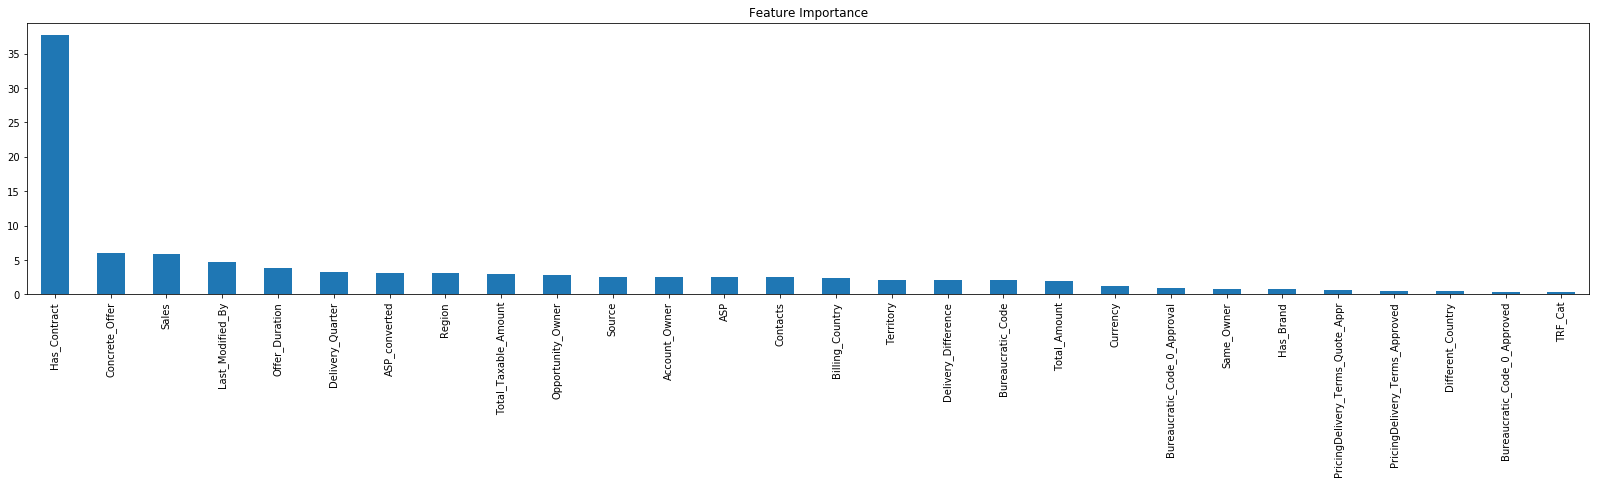

In [136]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')